## Load Data

Load the German traffic sign  data!

You do not need to modify this section.

In [1]:
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'train.p'
# validation_file=?
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
# with open(validation_file, mode='rb') as f:
#     valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
x_train, y_train = train['features'], train['labels']
# X_valid, y_valid = valid['features'], valid['labels']
x_test, y_test = test['features'], test['labels']

In [2]:
import numpy as np

# TODO: Number of training examples
n_train = len(x_train)

# TODO: Number of testing examples.
n_test = len(x_test)

# TODO: What's the shape of an traffic sign image?
image_shape = x_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


## Visualize Data

View a sample from the dataset.

You do not need to modify this section.

42


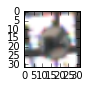

In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

index = random.randint(0, len(x_train))
image = x_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image, cmap="gray")
print(y_train[index])

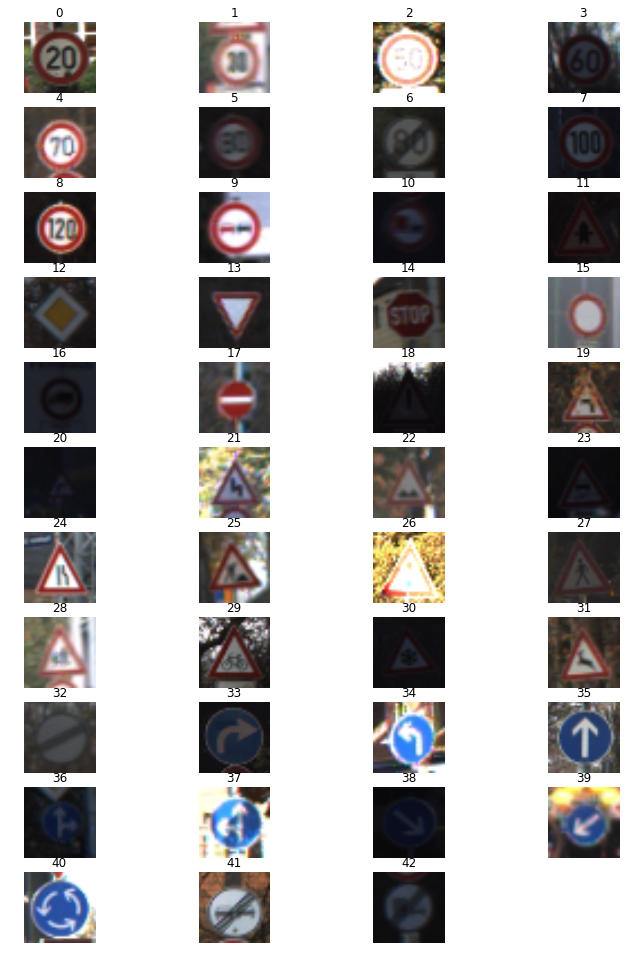

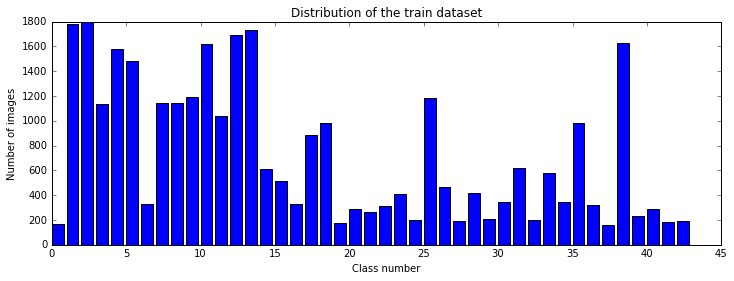

Min number of images per class = 161
Max number of images per class = 1799


In [8]:
%matplotlib inline

num_of_samples=[]
plt.figure(figsize=(12, 16.5))
for i in range(0, n_classes):
    plt.subplot(11, 4, i+1)
    x_selected = x_train[y_train == i]
    plt.imshow(x_selected[0, :, :, :]) #draw the first image of each class
    plt.title(i)
    plt.axis('off')
    num_of_samples.append(len(x_selected))
plt.show()

#Plot number of images per class
plt.figure(figsize=(12, 4))
plt.bar(range(0, n_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

print("Min number of images per class =", min(num_of_samples))
print("Max number of images per class =", max(num_of_samples))

In [10]:
from sklearn.model_selection import train_test_split
x_train,x_valid,y_train,y_valid=train_test_split(x_train,y_train,test_size=0.2,random_state=0)
print(x_train[0].shape)

(32, 32, 3)


## Preprocess Data

Shuffle the training data.

You do not need to modify this section.

In [11]:
x_train_gry=np.sum(x_train/3, axis=3, keepdims=True)
x_test_gry=np.sum(x_test/3, axis=3, keepdims=True)
x_valid_gry=np.sum(x_valid/3, axis=3, keepdims=True)

X_train=x_train_gry
X_test=x_test_gry
X_valid=x_valid_gry

In [12]:
X_train=(X_train-128)/128
X_test=(X_test-128)/128
X_valid=(X_valid-128)/128

In [15]:
X_train[0].shape

(32, 32, 1)

In [18]:
import cv2
def random_translate(img):
    rows,cols,_ = img.shape
    
    # allow translation up to px pixels in x and y directions
    px = 2
    dx,dy = np.random.randint(-px,px,2)

    M = np.float32([[1,0,dx],[0,1,dy]])
    dst = cv2.warpAffine(img,M,(cols,rows))
    
    dst = dst[:,:,np.newaxis]
    
    return dst

def random_scaling(img):   
    rows,cols,_ = img.shape

    # transform limits
    px = np.random.randint(-2,2)

    # ending locations
    pts1 = np.float32([[px,px],[rows-px,px],[px,cols-px],[rows-px,cols-px]])

    # starting locations (4 corners)
    pts2 = np.float32([[0,0],[rows,0],[0,cols],[rows,cols]])

    M = cv2.getPerspectiveTransform(pts1,pts2)

    dst = cv2.warpPerspective(img,M,(rows,cols))
    
    dst = dst[:,:,np.newaxis]
    
    return dst

def random_warp(img):
    
    rows,cols,_ = img.shape

    # random scaling coefficients
    rndx = np.random.rand(3) - 0.5
    rndx *= cols * 0.06   # this coefficient determines the degree of warping
    rndy = np.random.rand(3) - 0.5
    rndy *= rows * 0.06

    # 3 starting points for transform, 1/4 way from edges
    x1 = cols/4
    x2 = 3*cols/4
    y1 = rows/4
    y2 = 3*rows/4

    pts1 = np.float32([[y1,x1],
                       [y2,x1],
                       [y1,x2]])
    pts2 = np.float32([[y1+rndy[0],x1+rndx[0]],
                       [y2+rndy[1],x1+rndx[1]],
                       [y1+rndy[2],x2+rndx[2]]])

    M = cv2.getAffineTransform(pts1,pts2)

    dst = cv2.warpAffine(img,M,(cols,rows))
    
    dst = dst[:,:,np.newaxis]
    
    return dst

def random_brightness(img):
    shifted = img + 1.0   # shift to (0,2) range
    img_max_value = max(shifted.flatten())
    max_coef = 2.0/img_max_value
    min_coef = max_coef - 0.1
    coef = np.random.uniform(min_coef, max_coef)
    dst = shifted * coef - 1.0
    return dst

In [19]:
input_indices = []
output_indices = []

for class_n in range(n_classes):
    print(class_n, ': ', end='')
    class_indices = np.where(y_train == class_n)
    n_samples = len(class_indices[0])
    if n_samples < 800:
        for i in range(800 - n_samples):
            input_indices.append(class_indices[0][i%n_samples])
            output_indices.append(X_train.shape[0])
            new_img = X_train[class_indices[0][i % n_samples]]
            new_img = random_translate(random_scaling(random_warp(random_brightness(new_img))))
            X_train= np.concatenate((X_train, [new_img]), axis=0)
            y_train = np.concatenate((y_train, [class_n]), axis=0)
            if i % 50 == 0:
                print('|', end='')
            elif i % 10 == 0:
                print('-',end='')
    print('')
            
print('X, y shapes:', X_train.shape, y_train.shape)

0 : |----|----|----|----|----|----|----|----|----|----|----|----|----|
1 : 
2 : 
3 : 
4 : 
5 : 
6 : |----|----|----|----|----|----|----|----|----|----|---
7 : 
8 : 
9 : 
10 : 
11 : 
12 : 
13 : 
14 : |----|----|----|----|----|----|--
15 : |----|----|----|----|----|----|----|---
16 : |----|----|----|----|----|----|----|----|----|----|----
17 : |----|----
18 : |--
19 : |----|----|----|----|----|----|----|----|----|----|----|----|----|
20 : |----|----|----|----|----|----|----|----|----|----|----|-
21 : |----|----|----|----|----|----|----|----|----|----|----|----
22 : |----|----|----|----|----|----|----|----|----|----|----
23 : |----|----|----|----|----|----|----|----|----|-
24 : |----|----|----|----|----|----|----|----|----|----|----|----|---
25 : 
26 : |----|----|----|----|----|----|----|----|--
27 : |----|----|----|----|----|----|----|----|----|----|----|----|----
28 : |----|----|----|----|----|----|----|----|----|-
29 : |----|----|----|----|----|----|----|----|----|----|----|----|--
30 

In [23]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

## Setup TensorFlow
The `EPOCH` and `BATCH_SIZE` values affect the training speed and model accuracy.

You do not need to modify this section.

In [55]:
import tensorflow as tf

EPOCHS = 50
BATCH_SIZE = 120

This is the only cell you need to edit.
### Input
The LeNet architecture accepts a 32x32xC image as input, where C is the number of color channels.

### Architecture
**Layer 1: Convolutional.** 5x5x1x6 filter ,outputs 28X28X6.

**Activation.** Relu Activation.

**Pooling.** 2X2 filter with stride 2,outputs 14x14x6.

**Layer 2: Convolutional.** 5X5x6x16 filter,outputs 10x10x16

**Activation.** Relu Activation.

**Pooling.** 2X2 filter with stride 2,outputs 5x5x16.

**Layer 3: Convolutional.** 5X5x16x400 filter,outputs 1x1x400

**Activation.** Relu Activation.

**Flatten.** Concatenation of layer 2 and layer 3 after flattening,outputs 1x800

**Dropout.** Dropout with prob 0.5 on training data.

**Layer 5: Fully Connected (Logits).** Gives 43 outputs.

### Output

In [56]:
from tensorflow.contrib.layers import flatten

In [57]:
def traffic_sign(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    weights={
        'wc1':tf.Variable(tf.truncated_normal(shape=(5,5,1,6),mean = mu, stddev = sigma)),
        'wc2':tf.Variable(tf.truncated_normal(shape=(5,5,6,16),mean = mu, stddev = sigma)),
        'wc3':tf.Variable(tf.truncated_normal(shape=(5,5,16,400),mean = mu, stddev = sigma)),
        'out':tf.Variable(tf.truncated_normal(shape=(800,43),mean = mu, stddev = sigma))
    }
    biases={
        'bc1':tf.Variable(tf.zeros((6,))),
        'bc2':tf.Variable(tf.zeros((16,))),
        'bc3':tf.Variable(tf.zeros((400,))),
        'out':tf.Variable(tf.zeros((43,)))
    }
    
    
    # TODO: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    layer1=tf.nn.conv2d(x,weights['wc1'],strides=[1,1,1,1],padding='VALID')+biases['bc1']
    # TODO: Activation.
    layer1=tf.nn.relu(layer1)
    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    layer1=tf.nn.max_pool(layer1,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
    print(layer1.get_shape())
    #Dropout
    #layer1=tf.nn.dropout(layer1,0.6)
    #print(layer1.shape)
    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    layer2=tf.nn.conv2d(layer1,weights['wc2'],strides=[1,1,1,1],padding='VALID')+biases['bc2']
    # TODO: Activation.
    layer2=tf.nn.relu(layer2)
    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    layer2=tf.nn.max_pool(layer2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
    print(layer2.get_shape())
    #Dropout
    layer3=tf.nn.conv2d(layer2,weights['wc3'],strides=[1,1,1,1],padding='VALID')+biases['bc3']
    # TODO: Activation.
    layer3=tf.nn.relu(layer3)
    print(layer3.get_shape())
    layer2_flat=flatten(layer2)
    layer3_flat=flatten(layer3)
#   
    layer4=tf.concat_v2([layer3_flat, layer2_flat], 1)
    layer4=tf.nn.dropout(layer4,keep_prob)
    
    logits=tf.add(tf.matmul(layer4,weights['out']),biases['out'])
    
    return logits

## Features and Labels
Train LeNet to classify [MNIST](http://yann.lecun.com/exdb/mnist/) data.

`x` is a placeholder for a batch of input images.
`y` is a placeholder for a batch of output labels.

You do not need to modify this section.

In [58]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
keep_prob=tf.placeholder(tf.float32)

## Training Pipeline
Create a training pipeline that uses the model to classify MNIST data.

You do not need to modify this section.

In [60]:
rate = 0.0009
KEEP_PROB = 0.5
logits = traffic_sign(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

(?, 14, 14, 6)
(?, 5, 5, 16)
(?, 1, 1, 400)


## Model Evaluation
Evaluate how well the loss and accuracy of the model for a given dataset.

You do not need to modify this section.

In [61]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y,keep_prob:1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## Train the Model
Run the training data through the training pipeline to train the model.

Before each epoch, shuffle the training set.

After each epoch, measure the loss and accuracy of the validation set.

Save the model after training.

You do not need to modify this section.

In [62]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y,keep_prob:KEEP_PROB})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.872

EPOCH 2 ...
Validation Accuracy = 0.934

EPOCH 3 ...
Validation Accuracy = 0.958

EPOCH 4 ...
Validation Accuracy = 0.968

EPOCH 5 ...
Validation Accuracy = 0.970

EPOCH 6 ...
Validation Accuracy = 0.980

EPOCH 7 ...
Validation Accuracy = 0.976

EPOCH 8 ...
Validation Accuracy = 0.984

EPOCH 9 ...
Validation Accuracy = 0.985

EPOCH 10 ...
Validation Accuracy = 0.987

EPOCH 11 ...
Validation Accuracy = 0.989

EPOCH 12 ...
Validation Accuracy = 0.990

EPOCH 13 ...
Validation Accuracy = 0.990

EPOCH 14 ...
Validation Accuracy = 0.989

EPOCH 15 ...
Validation Accuracy = 0.989

EPOCH 16 ...
Validation Accuracy = 0.990

EPOCH 17 ...
Validation Accuracy = 0.991

EPOCH 18 ...
Validation Accuracy = 0.991

EPOCH 19 ...
Validation Accuracy = 0.992

EPOCH 20 ...
Validation Accuracy = 0.993

EPOCH 21 ...
Validation Accuracy = 0.991

EPOCH 22 ...
Validation Accuracy = 0.992

EPOCH 23 ...
Validation Accuracy = 0.990

EPOCH 24 ...
Validation Accura

## Evaluate the Model
Once you are completely satisfied with your model, evaluate the performance of the model on the test set.

Be sure to only do this once!

If you were to measure the performance of your trained model on the test set, then improve your model, and then measure the performance of your model on the test set again, that would invalidate your test results. You wouldn't get a true measure of how well your model would perform against real data.

You do not need to modify this section.

In [63]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.946


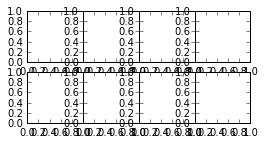

In [96]:
import glob
import matplotlib.image as mpimg
fig, axs = plt.subplots(2,4, figsize=(4, 2))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

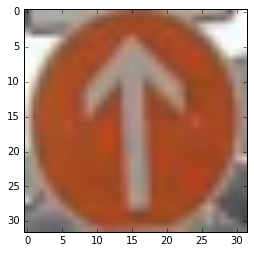

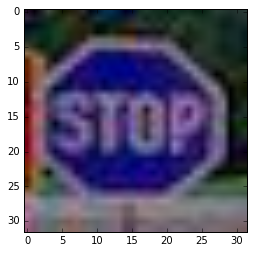

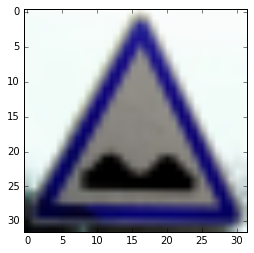

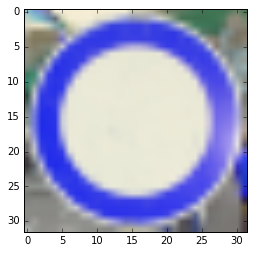

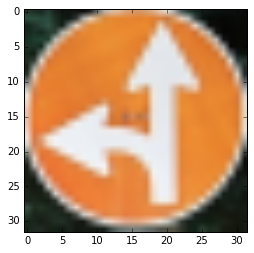

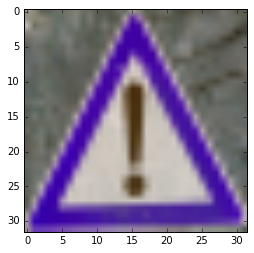

In [112]:
new_images=[]
new_labels=[35,14,22,15,37,18]
for i, img in enumerate(glob.glob('./new_images/*.jpg')):
    image = cv2.imread(img)
    axs[i].axis('off')
    axs[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    new_images.append(image)
new_images=np.asarray(new_images)
new_labels=np.asarray(new_labels)

for i in range(len(new_images)):
#     print(new_images[i].shape)
    plt.imshow(new_images[i])
    plt.show()

# Normalizing and preprocessing new images

In [113]:
my_images=new_images
new_images=np.sum(new_images/3, axis=3, keepdims=True)
new_images=(new_images-128)/128

In [104]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(new_images, new_labels)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 1.000


# Softmax Probabilities 

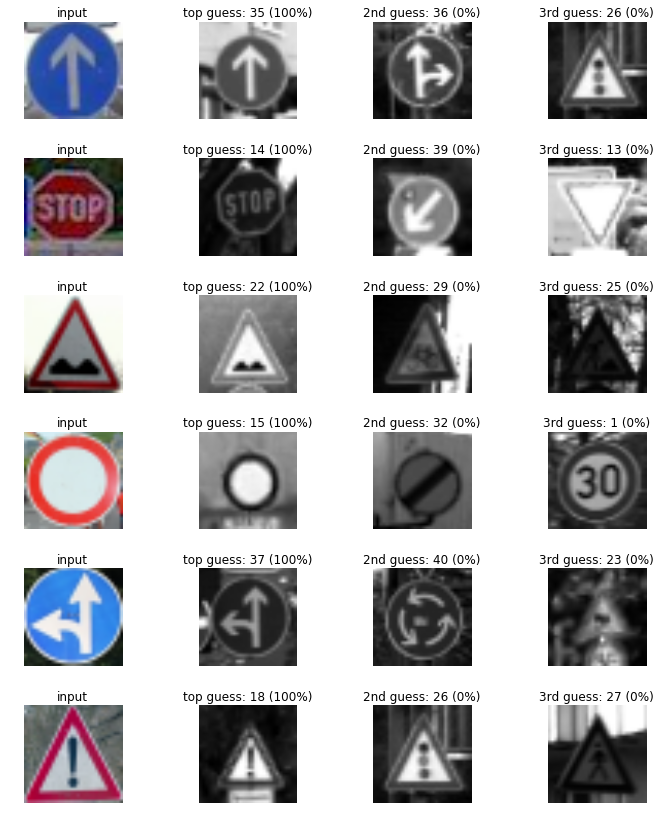

In [116]:
softmax_logits = tf.nn.softmax(logits)
top_k = tf.nn.top_k(softmax_logits, k=3)


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph('./lenet.meta')
    saver.restore(sess, "./lenet")
    my_softmax_logits = sess.run(softmax_logits, feed_dict={x: new_images, keep_prob: 1.0})
    my_top_k = sess.run(top_k, feed_dict={x: new_images, keep_prob: 1.0})

    
    fig, axs = plt.subplots(len(new_images),4, figsize=(12, 14))
    fig.subplots_adjust(hspace = .4, wspace=.2)
    axs = axs.ravel()

    for i, image in enumerate(my_images):
        axs[4*i].axis('off')
        axs[4*i].imshow(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        axs[4*i].set_title('input')
        guess1 = my_top_k[1][i][0]
        index1 = np.argwhere(y_valid == guess1)[0]
        axs[4*i+1].axis('off')
        axs[4*i+1].imshow(X_valid[index1].squeeze(), cmap='gray')
        axs[4*i+1].set_title('top guess: {} ({:.0f}%)'.format(guess1, 100*my_top_k[0][i][0]))
        guess2 = my_top_k[1][i][1]
        index2 = np.argwhere(y_valid == guess2)[0]
        axs[4*i+2].axis('off')
        axs[4*i+2].imshow(X_valid[index2].squeeze(), cmap='gray')
        axs[4*i+2].set_title('2nd guess: {} ({:.0f}%)'.format(guess2, 100*my_top_k[0][i][1]))
        guess3 = my_top_k[1][i][2]
        index3 = np.argwhere(y_valid == guess3)[0]
        axs[4*i+3].axis('off')
        axs[4*i+3].imshow(X_valid[index3].squeeze(), cmap='gray')
        axs[4*i+3].set_title('3rd guess: {} ({:.0f}%)'.format(guess3, 100*my_top_k[0][i][2]))

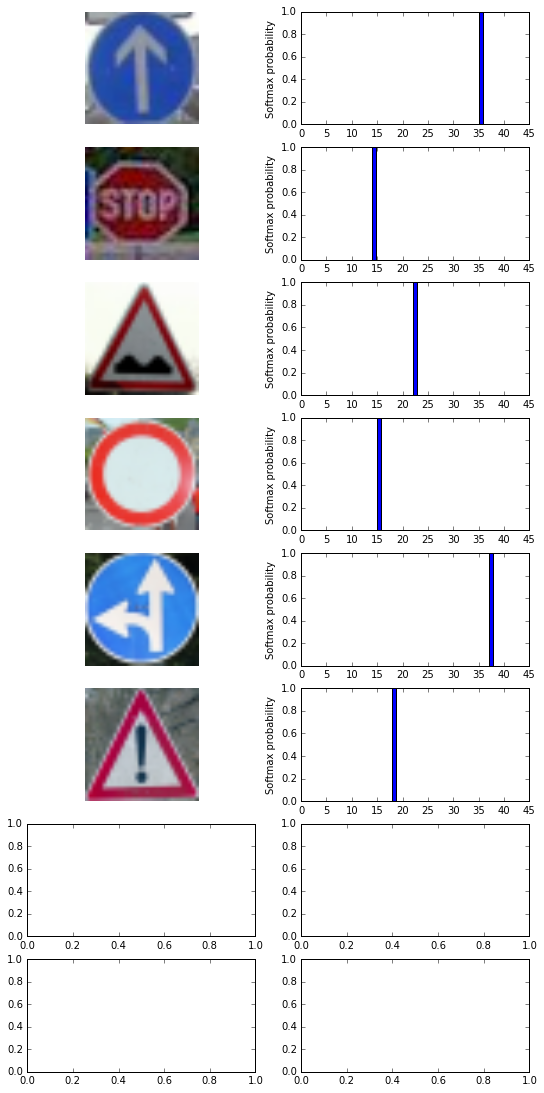

In [119]:
fig, axs = plt.subplots(8,2, figsize=(9, 19))
axs = axs.ravel()

for i in range(len(my_softmax_logits)*2):
    if i%2 == 0:
        axs[i].axis('off')
        axs[i].imshow(cv2.cvtColor(my_images[i//2], cv2.COLOR_BGR2RGB))
    else:
        axs[i].bar(np.arange(n_classes), my_softmax_logits[(i-1)//2]) 
        axs[i].set_ylabel('Softmax probability')